<Body>   
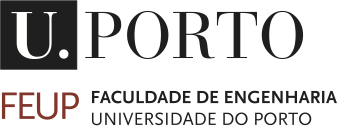   
<h1> <b>Computer Vision </b> </h1>
</Body>  

<br>**Master in Data Science & Engineering**     <br><br> **Assigment 2**  <br><br> **Diogo Cruz - Vitor Pereira**  <br>
<br> Faculty of Engineering, University of Porto <br>FEUP Nov. 2023

# CAPTCHA Decoding

<h2>Table of contents</h2>
<div class="alert alert-block alert-info" style="margin-top: 20px">
<ol>
    <li><a href="#ref1">Introduction</a></li>
    <li><a href="#ref2">Data loading</a></li>
    <li><a href="#ref3">Data preparation</a></li>
    <li><a href="#ref4">Network architecture</a></li>
    <li><a href="#ref5">Soft dataset</a></li>
      <ol type="I">
            <li><a href="#ref5-1">Training evolution</a></li>
            <li><a href="#ref5-2">Confusion matrix</a></li>
            <li><a href="#ref5-3">Predictions</a></li>
      </ol>
      <li><a href="#ref6">Hard dataset</a></li>
      <ol type="I">
            <li><a href="#ref6-1">Training evolution</a></li>
            <li><a href="#ref6-2">Confusion matrix</a></li>
            <li><a href="#ref6-3">Predictions</a></li>
      </ol>
      <li><a href="#ref7">Conclusion, limitations & future work</a></li>
      <ol type="I">
            <li><a href="#ref7-1">Limitations</a></li>
            <li><a href="#ref7-2">Future work</a></li>
            <li><a href="#ref7-3">Conclusions</a></li>
      </ol>
</ol>
<p></p>
</div>
<hr>

<a id="ref1"></a>
## Introduction

- Captchas **(Completely Automated Public Turing test to tell Computers and Humans Apart)** are widely used to secure online forms and prevent automated bots from accessing certain services.

- Nowadays Captchas have become to more complex challenges involving distorted text, puzzles, and dynamic elements.

- The goal of our project is to train a Covolutional Neural Network with ability to decode Captchas.

<a id="ref2"></a>
## Data loading

In [ ]:
# Download data from public google colab
!gdown "1S1HYV9VSBz87tkdgYUoGvXiECuTG-sey"


Downloading...
From: https://drive.google.com/uc?id=1S1HYV9VSBz87tkdgYUoGvXiECuTG-sey
To: /content/CAPTCHA_dataset.zip
100% 116M/116M [00:03<00:00, 38.8MB/s]


In [ ]:
# Unzip the data
!unzip CAPTCHA_dataset.zip -d CAPTCHA_dataset

A saída de streaming foi truncada nas últimas 5000 linhas.
 extracting: CAPTCHA_dataset/CAPTCHA_dataset/soft/train/34940.png  
  inflating: CAPTCHA_dataset/CAPTCHA_dataset/soft/train/34hn.png  
 extracting: CAPTCHA_dataset/CAPTCHA_dataset/soft/train/34i0.png  
 extracting: CAPTCHA_dataset/CAPTCHA_dataset/soft/train/34tkf.png  
 extracting: CAPTCHA_dataset/CAPTCHA_dataset/soft/train/35030.png  
 extracting: CAPTCHA_dataset/CAPTCHA_dataset/soft/train/35105.png  
 extracting: CAPTCHA_dataset/CAPTCHA_dataset/soft/train/35147.png  
 extracting: CAPTCHA_dataset/CAPTCHA_dataset/soft/train/3515.png  
 extracting: CAPTCHA_dataset/CAPTCHA_dataset/soft/train/35201.png  
 extracting: CAPTCHA_dataset/CAPTCHA_dataset/soft/train/35219.png  
 extracting: CAPTCHA_dataset/CAPTCHA_dataset/soft/train/35324.png  
 extracting: CAPTCHA_dataset/CAPTCHA_dataset/soft/train/3533.png  
 extracting: CAPTCHA_dataset/CAPTCHA_dataset/soft/train/3535.png  
 extracting: CAPTCHA_dataset/CAPTCHA_dataset/soft/train/3538.p

<a id="ref3"></a>
## Data preparation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from torchsummary import summary
import os
import string
import cv2 as cv2
from PIL import Image
import glob

In [ ]:
class captchaDataset(Dataset):
    def __init__(self, data_dir, images, train=True):
        self.data_dir = data_dir
        self.images = images
        self.train = train


    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        data_point = self.images[index]
        img_path = os.path.join(self.data_dir, data_point)
        image = Image.open(img_path).convert('L')
        if train == True:
          image = self.transform(image, normalize=True)
          label = self.images[index][:-4]
          label_encoded = self.label_encoding(label, string.ascii_lowercase + string.digits + '!')
          label_encoded = torch.from_numpy(label_encoded)
        else:
          image = self.transform(image)
          label = self.images[index][:-4]
          label_encoded = self.label_encoding(label, string.ascii_lowercase + string.digits + '!')
          label_encoded = torch.from_numpy(label_encoded)

        return image, label, label_encoded


    def transform(self, image, normalize=False):
      if normalize == False:
        transform_op = transforms.Compose([
            transforms.ToTensor()])
      else:
        transform_op = transforms.Compose([
            transforms.RandomPerspective(distortion_scale=0.2, p=0.4),
            transforms.RandomRotation(40),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomAdjustSharpness(0.5),
            transforms.ToTensor()])
      return transform_op(image)


    def label_encoding(self, imgLabel, char):
      target=np.zeros((5, len(char)))

      for i,k in enumerate(imgLabel):
          index = char.find(k)
          target[i, index] = 1

      if len(imgLabel) == 4:
          target[4, len(char)-1] = 1

      return np.array(target).flatten()


In [ ]:
train_data_soft = captchaDataset(data_dir='/content/CAPTCHA_dataset/CAPTCHA_dataset/soft/train/',
                           images=os.listdir('/content/CAPTCHA_dataset/CAPTCHA_dataset/soft/train/'))
test_data_soft = captchaDataset(data_dir='/content/CAPTCHA_dataset/CAPTCHA_dataset/soft/test/',
                           images=os.listdir('/content/CAPTCHA_dataset/CAPTCHA_dataset/soft/test/'), train=False)


train_data_hard = captchaDataset(data_dir='/content/CAPTCHA_dataset/CAPTCHA_dataset/hard/train/',
                                 images=os.listdir('/content/CAPTCHA_dataset/CAPTCHA_dataset/hard/train/'))
test_data_hard = captchaDataset(data_dir='/content/CAPTCHA_dataset/CAPTCHA_dataset/hard/test/',
                                 images=os.listdir('/content/CAPTCHA_dataset/CAPTCHA_dataset/hard/test/'), train=False)

In [ ]:
# Split the training dataset into train and validation sets
def split_dataset(train_data, test_data, split_size):
    if not isinstance(split_size, float):
        raise TypeError("split_size must be a float")

    indices = list(range(len(train_data)))
    np.random.shuffle(indices)

    val_split = int(np.floor(split_size * len(train_data)))
    train_idx, val_idx = indices[val_split:], indices[:val_split]

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    print(f'Training size: {len(train_idx)}\nValidation size: {len(val_idx)}\nTest size: {len(test_data)}')

    return train_sampler, val_sampler

In [ ]:
train_sampler_soft, val_sampler_soft = split_dataset(train_data_soft, test_data_soft, 0.1)
print('')
train_sampler_hard, val_sampler_hard = split_dataset(train_data_hard, test_data_hard, 0.1)

Training size: 5707
Validation size: 634
Test size: 1432

Training size: 5089
Validation size: 565
Test size: 1433


In [ ]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

def get_final_data(train_data, test_data, train_sampler, val_sampler, batch_size, num_workers):
  # get train data
  train_dataloader = DataLoader(train_data, batch_size=batch_size,
                                num_workers=num_workers, sampler=train_sampler)
  # get validation data
  validation_dataloader = DataLoader(train_data, sampler=val_sampler,
                                    batch_size=1, num_workers=num_workers, drop_last=False)
  # get test data
  test_dataloader = DataLoader(test_data, batch_size=1,
                              shuffle=False, num_workers=num_workers, drop_last=False)

  return train_dataloader, validation_dataloader, test_dataloader

Using cuda device


In [ ]:
train_dataloader_soft, validation_dataloader_soft, test_dataloader_soft = get_final_data(train_data_soft, test_data_soft,
                                                                          train_sampler_soft, val_sampler_soft, 64, 0)

train_dataloader_hard, validation_dataloader_hard, test_dataloader_hard = get_final_data(train_data_hard, test_data_hard,
                                                                          train_sampler_hard, val_sampler_hard, 64,0)

To accomplish our goal, we loaded both datasets: **soft** and **hard**. The difference between them is the addition of strange characters in Hard dataset. These strange characters may cause confusion in our model, making each prediction more dificult.

Once we had string labels, was necessary to encode each label in order to make them understandable to the model. Each label had available 37 characters (all the letters, all the numbers and a '!' as a flag - for the four-letter labels), so we applied one hot encoding to all the labels.


Some data augmentation was also applied to feed the model with more diversity with regard to the train data. This technique helped the model to become more robust and generalized better the unseen data.

<a id="ref4"></a>
## Network architecture

Our **CNN** architecture was designed to follow a sequential pattern of convolutional and fully connected layers, aiming to decode **CAPTCHA** images with either 4 or 5 encoders characters.

**Convolutional Layers:**


- Begins with a series of convolutional operations (Conv2d) with increasing filter depths (from 1 to 512) and ReLU activation functions, promoting feature extraction.
- Batch normalization is applied after each convolutional layer to stabilize and accelerate training.
- Max pooling layers are incorporated to downsample the feature maps, enhancing computational efficiency while preserving essential features.
- Dropout layers (with a dropout rate of 0.2) are strategically placed to prevent overfitting.
- Introduces an extra convolutional layer (Conv2d) with 512 filters and ReLU activation.
- Implements batch normalization, dropout (0.2), and an average pooling layer for further feature extraction and reduction.

**Flattening and Fully Connected Layers:**

- The output from convolutional layers is flattened to be fed into the fully connected layers.
- Two fully connected (Linear) layers follow, with ReLU activation in between and a dropout rate of 0.3 in the first FC layer.

The final FC layer generates output predictions based on the specified number of classes (185 = max_characters_per_captcha(5) * possible_characters(37)) representing the possible character combinations in the CAPTCHA dataset.

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Dropout(0.2),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.flatten_size = 512 * 3 * 6

        self.fc_layers = nn.Sequential(
            nn.Linear(self.flatten_size, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc_layers(x)
        return x

num_classes = 185
model = CustomCNN(num_classes).to(device)

In [ ]:
summary(model, (1, 100, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 100, 200]             320
              ReLU-2         [-1, 32, 100, 200]               0
       BatchNorm2d-3         [-1, 32, 100, 200]              64
         MaxPool2d-4          [-1, 32, 50, 100]               0
            Conv2d-5          [-1, 64, 50, 100]          18,496
              ReLU-6          [-1, 64, 50, 100]               0
       BatchNorm2d-7          [-1, 64, 50, 100]             128
           Dropout-8          [-1, 64, 50, 100]               0
         MaxPool2d-9           [-1, 64, 25, 50]               0
           Conv2d-10          [-1, 128, 25, 50]          73,856
             ReLU-11          [-1, 128, 25, 50]               0
      BatchNorm2d-12          [-1, 128, 25, 50]             256
        MaxPool2d-13          [-1, 128, 12, 25]               0
           Conv2d-14          [-1, 256,

In [ ]:
char = string.ascii_lowercase + string.digits + '!'

# All symbols captcha can contain + special character
characters = string.ascii_lowercase + "0123456789" + "!"

# Total number of characters possibles
characters_len = len(characters)

In [ ]:
def decode_label(pred):
  c0 = characters[np.argmax(pred.squeeze().cpu().tolist()[0:characters_len])]
  c1 = characters[np.argmax(pred.squeeze().cpu().tolist()[characters_len:characters_len*2])]
  c2 = characters[np.argmax(pred.squeeze().cpu().tolist()[characters_len*2:characters_len*3])]
  c3 = characters[np.argmax(pred.squeeze().cpu().tolist()[characters_len*3:characters_len*4])]
  c4 = characters[np.argmax(pred.squeeze().cpu().tolist()[characters_len*4:characters_len*5])]

  if(c4 == "!"):
    label_pred = '%s%s%s%s' % (c0, c1, c2, c3)
  else:
    label_pred = '%s%s%s%s%s' % (c0, c1, c2, c3, c4)

  return label_pred

In [ ]:
def getAcc(pred, label):
  count = 0

  for i in range(0, len(pred)):
    predicted_label = decode_label(pred[i])
    if label[i] == predicted_label:
      count += 1

  return count

In [ ]:
def train(dataloader, model, loss_fn, optimizer=None):
  assert optimizer is not None, "Please provide an optimizer"

  num_batches = 64

  model.train()
  total_loss = 0.0
  acc = 0

  for batch, (img, label, label_enc) in enumerate(tqdm(dataloader)):
    # unpack tuples
    img, label_enc = img.to(device), label_enc.float().to(device)

    # predict the output
    pred = model(img)

    # Set gradients to zero
    optimizer.zero_grad()

    acc += getAcc(pred, label)

    # Compute loss
    loss = loss_fn(pred, label_enc)

    # Backpropagation
    loss.backward()

    # Update parameters
    optimizer.step()

    # Update loss
    total_loss += loss.item()

  total_acc = acc / (len(dataloader) * num_batches)

  return total_loss, total_acc

In [ ]:
# This function evaluate the model
def evaluate(dataloader,
            model,
            loss_fn):
  # Initializing some variables
  val_loss = 0
  count = 0
  model.eval()
  for step, (img, label, label_oh) in enumerate(tqdm(dataloader)):

    img = (img).to(device)
    label_oh = (label_oh.float()).to(device)

    # Predict the output of image
    pred = model(img)

    # Get loss of prediction
    loss = loss_fn(pred, label_oh)

    # Sum of loss of all instances
    val_loss += loss.item()

    # Label predict
    label_pred = decode_label(pred)
    #print(label_pred)

    # Count numbers of success predict
    if(label[0] == label_pred):
      count+= 1

  acc = count/len(dataloader)

  return acc, val_loss/len(dataloader)

In [ ]:
# Using MultiLabelSoftMarginLoss
loss_fn = nn.MultiLabelSoftMarginLoss().to(device)

# Using Adam optimizator with a low learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [ ]:
def run_model(train_dataloader, validation_dataloader, model_name1, model_name2, num_epochs = 400, model=model, loss_fn=loss_fn, optimizer=optimizer):
  train_history = {'loss': [], 'accuracy': []}
  val_history = {'loss': [], 'accuracy': []}
  best_val_loss = np.inf

  for t in range(num_epochs):
    print(f'\n Epoch {t+1}')
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
    print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")
    val_acc, val_loss = evaluate(validation_dataloader, model, loss_fn)
    print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")

     # save model when val loss improves
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, model_name1)

    # save latest model
    save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
    torch.save(save_dict, model_name2)

    # save training history for plotting purposes
    train_history["loss"].append(train_loss)
    train_history["accuracy"].append(train_acc)

    val_history["loss"].append(val_loss)
    val_history["accuracy"].append(val_acc)

  print("Finished")

  return train_history, val_history

<a id="ref5"></a>
# Soft Dataset

In [ ]:
train_history_soft, val_history_soft = run_model(train_dataloader_soft, validation_dataloader_soft,'best_model_soft.pth',
                                                 'latest_model_soft.pth',num_epochs=100)


 Epoch 1


100%|██████████| 90/90 [00:13<00:00,  6.91it/s]


Train loss: 11.649 	 Train acc: 0.001


100%|██████████| 634/634 [00:01<00:00, 382.61it/s]


Val loss: 0.107 	 Val acc: 0.002

 Epoch 2


100%|██████████| 90/90 [00:11<00:00,  7.52it/s]


Train loss: 8.588 	 Train acc: 0.007


100%|██████████| 634/634 [00:01<00:00, 361.02it/s]


Val loss: 0.085 	 Val acc: 0.017

 Epoch 3


100%|██████████| 90/90 [00:11<00:00,  7.59it/s]


Train loss: 6.223 	 Train acc: 0.081


100%|██████████| 634/634 [00:01<00:00, 323.27it/s]


Val loss: 0.063 	 Val acc: 0.139

 Epoch 4


100%|██████████| 90/90 [00:12<00:00,  7.33it/s]


Train loss: 4.495 	 Train acc: 0.218


100%|██████████| 634/634 [00:04<00:00, 154.83it/s]


Val loss: 0.052 	 Val acc: 0.243

 Epoch 5


100%|██████████| 90/90 [00:11<00:00,  7.56it/s]


Train loss: 3.233 	 Train acc: 0.375


100%|██████████| 634/634 [00:01<00:00, 351.03it/s]


Val loss: 0.045 	 Val acc: 0.339

 Epoch 6


100%|██████████| 90/90 [00:11<00:00,  7.62it/s]


Train loss: 2.250 	 Train acc: 0.556


100%|██████████| 634/634 [00:01<00:00, 380.59it/s]


Val loss: 0.043 	 Val acc: 0.355

 Epoch 7


100%|██████████| 90/90 [00:11<00:00,  7.54it/s]


Train loss: 1.597 	 Train acc: 0.703


100%|██████████| 634/634 [00:01<00:00, 372.79it/s]


Val loss: 0.048 	 Val acc: 0.409

 Epoch 8


100%|██████████| 90/90 [00:11<00:00,  7.50it/s]


Train loss: 1.137 	 Train acc: 0.813


100%|██████████| 634/634 [00:01<00:00, 377.13it/s]


Val loss: 0.043 	 Val acc: 0.426

 Epoch 9


100%|██████████| 90/90 [00:12<00:00,  7.49it/s]


Train loss: 0.825 	 Train acc: 0.890


100%|██████████| 634/634 [00:01<00:00, 382.29it/s]


Val loss: 0.062 	 Val acc: 0.345

 Epoch 10


100%|██████████| 90/90 [00:11<00:00,  7.53it/s]


Train loss: 0.612 	 Train acc: 0.934


100%|██████████| 634/634 [00:01<00:00, 382.17it/s]


Val loss: 0.059 	 Val acc: 0.409

 Epoch 11


100%|██████████| 90/90 [00:11<00:00,  7.51it/s]


Train loss: 0.483 	 Train acc: 0.950


100%|██████████| 634/634 [00:01<00:00, 382.50it/s]


Val loss: 0.053 	 Val acc: 0.461

 Epoch 12


100%|██████████| 90/90 [00:12<00:00,  7.28it/s]


Train loss: 0.407 	 Train acc: 0.965


100%|██████████| 634/634 [00:02<00:00, 312.76it/s]


Val loss: 0.058 	 Val acc: 0.450

 Epoch 13


100%|██████████| 90/90 [00:11<00:00,  7.52it/s]


Train loss: 0.343 	 Train acc: 0.970


100%|██████████| 634/634 [00:01<00:00, 386.91it/s]


Val loss: 0.061 	 Val acc: 0.440

 Epoch 14


100%|██████████| 90/90 [00:11<00:00,  7.56it/s]


Train loss: 0.281 	 Train acc: 0.977


100%|██████████| 634/634 [00:01<00:00, 383.24it/s]


Val loss: 0.067 	 Val acc: 0.448

 Epoch 15


100%|██████████| 90/90 [00:11<00:00,  7.58it/s]


Train loss: 0.246 	 Train acc: 0.979


100%|██████████| 634/634 [00:01<00:00, 389.39it/s]


Val loss: 0.064 	 Val acc: 0.461

 Epoch 16


100%|██████████| 90/90 [00:12<00:00,  7.49it/s]


Train loss: 0.223 	 Train acc: 0.980


100%|██████████| 634/634 [00:01<00:00, 380.29it/s]


Val loss: 0.054 	 Val acc: 0.489

 Epoch 17


100%|██████████| 90/90 [00:12<00:00,  7.47it/s]


Train loss: 0.216 	 Train acc: 0.983


100%|██████████| 634/634 [00:01<00:00, 376.83it/s]


Val loss: 0.057 	 Val acc: 0.492

 Epoch 18


100%|██████████| 90/90 [00:12<00:00,  7.46it/s]


Train loss: 0.192 	 Train acc: 0.983


100%|██████████| 634/634 [00:01<00:00, 379.46it/s]


Val loss: 0.067 	 Val acc: 0.442

 Epoch 19


100%|██████████| 90/90 [00:11<00:00,  7.52it/s]


Train loss: 0.194 	 Train acc: 0.982


100%|██████████| 634/634 [00:01<00:00, 385.26it/s]


Val loss: 0.066 	 Val acc: 0.491

 Epoch 20


100%|██████████| 90/90 [00:11<00:00,  7.54it/s]


Train loss: 0.182 	 Train acc: 0.982


100%|██████████| 634/634 [00:01<00:00, 377.68it/s]


Val loss: 0.072 	 Val acc: 0.465

 Epoch 21


100%|██████████| 90/90 [00:11<00:00,  7.53it/s]


Train loss: 0.160 	 Train acc: 0.985


100%|██████████| 634/634 [00:01<00:00, 379.60it/s]


Val loss: 0.070 	 Val acc: 0.489

 Epoch 22


100%|██████████| 90/90 [00:11<00:00,  7.50it/s]


Train loss: 0.163 	 Train acc: 0.985


100%|██████████| 634/634 [00:01<00:00, 367.34it/s]


Val loss: 0.111 	 Val acc: 0.396

 Epoch 23


100%|██████████| 90/90 [00:11<00:00,  7.52it/s]


Train loss: 0.154 	 Train acc: 0.984


100%|██████████| 634/634 [00:01<00:00, 383.00it/s]


Val loss: 0.081 	 Val acc: 0.453

 Epoch 24


100%|██████████| 90/90 [00:11<00:00,  7.54it/s]


Train loss: 0.139 	 Train acc: 0.986


100%|██████████| 634/634 [00:01<00:00, 375.90it/s]


Val loss: 0.077 	 Val acc: 0.459

 Epoch 25


100%|██████████| 90/90 [00:11<00:00,  7.55it/s]


Train loss: 0.135 	 Train acc: 0.987


100%|██████████| 634/634 [00:01<00:00, 362.30it/s]


Val loss: 0.089 	 Val acc: 0.442

 Epoch 26


100%|██████████| 90/90 [00:11<00:00,  7.53it/s]


Train loss: 0.142 	 Train acc: 0.985


100%|██████████| 634/634 [00:01<00:00, 334.55it/s]


Val loss: 0.149 	 Val acc: 0.399

 Epoch 27


100%|██████████| 90/90 [00:11<00:00,  7.62it/s]


Train loss: 0.160 	 Train acc: 0.983


100%|██████████| 634/634 [00:02<00:00, 304.65it/s]


Val loss: 0.108 	 Val acc: 0.185

 Epoch 28


100%|██████████| 90/90 [00:11<00:00,  7.74it/s]


Train loss: 0.178 	 Train acc: 0.982


100%|██████████| 634/634 [00:02<00:00, 285.26it/s]


Val loss: 0.079 	 Val acc: 0.468

 Epoch 29


100%|██████████| 90/90 [00:11<00:00,  7.68it/s]


Train loss: 0.153 	 Train acc: 0.983


100%|██████████| 634/634 [00:02<00:00, 285.42it/s]


Val loss: 0.104 	 Val acc: 0.442

 Epoch 30


100%|██████████| 90/90 [00:11<00:00,  7.72it/s]


Train loss: 0.181 	 Train acc: 0.979


100%|██████████| 634/634 [00:02<00:00, 296.72it/s]


Val loss: 0.060 	 Val acc: 0.527

 Epoch 31


100%|██████████| 90/90 [00:11<00:00,  7.69it/s]


Train loss: 0.141 	 Train acc: 0.985


100%|██████████| 634/634 [00:01<00:00, 319.23it/s]


Val loss: 0.109 	 Val acc: 0.435

 Epoch 32


100%|██████████| 90/90 [00:11<00:00,  7.66it/s]


Train loss: 0.128 	 Train acc: 0.985


100%|██████████| 634/634 [00:01<00:00, 338.28it/s]


Val loss: 0.077 	 Val acc: 0.497

 Epoch 33


100%|██████████| 90/90 [00:11<00:00,  7.64it/s]


Train loss: 0.119 	 Train acc: 0.986


100%|██████████| 634/634 [00:01<00:00, 360.25it/s]


Val loss: 0.144 	 Val acc: 0.432

 Epoch 34


100%|██████████| 90/90 [00:12<00:00,  7.31it/s]


Train loss: 0.153 	 Train acc: 0.981


100%|██████████| 634/634 [00:01<00:00, 374.80it/s]


Val loss: 0.231 	 Val acc: 0.399

 Epoch 35


100%|██████████| 90/90 [00:13<00:00,  6.86it/s]


Train loss: 0.134 	 Train acc: 0.986


100%|██████████| 634/634 [00:01<00:00, 362.97it/s]


Val loss: 0.086 	 Val acc: 0.495

 Epoch 36


100%|██████████| 90/90 [00:11<00:00,  7.54it/s]


Train loss: 0.137 	 Train acc: 0.985


100%|██████████| 634/634 [00:01<00:00, 392.13it/s]


Val loss: 0.142 	 Val acc: 0.434

 Epoch 37


100%|██████████| 90/90 [00:11<00:00,  7.52it/s]


Train loss: 0.113 	 Train acc: 0.987


100%|██████████| 634/634 [00:01<00:00, 383.28it/s]


Val loss: 0.198 	 Val acc: 0.415

 Epoch 38


100%|██████████| 90/90 [00:11<00:00,  7.62it/s]


Train loss: 0.108 	 Train acc: 0.987


100%|██████████| 634/634 [00:01<00:00, 384.77it/s]


Val loss: 0.106 	 Val acc: 0.350

 Epoch 39


100%|██████████| 90/90 [00:11<00:00,  7.51it/s]


Train loss: 0.119 	 Train acc: 0.986


100%|██████████| 634/634 [00:01<00:00, 374.53it/s]


Val loss: 0.157 	 Val acc: 0.139

 Epoch 40


100%|██████████| 90/90 [00:11<00:00,  7.52it/s]


Train loss: 0.118 	 Train acc: 0.986


100%|██████████| 634/634 [00:01<00:00, 359.17it/s]


Val loss: 0.074 	 Val acc: 0.511

 Epoch 41


100%|██████████| 90/90 [00:11<00:00,  7.53it/s]


Train loss: 0.117 	 Train acc: 0.986


100%|██████████| 634/634 [00:01<00:00, 384.76it/s]


Val loss: 0.205 	 Val acc: 0.360

 Epoch 42


100%|██████████| 90/90 [00:11<00:00,  7.52it/s]


Train loss: 0.108 	 Train acc: 0.988


100%|██████████| 634/634 [00:01<00:00, 329.40it/s]


Val loss: 0.204 	 Val acc: 0.402

 Epoch 43


100%|██████████| 90/90 [00:12<00:00,  7.28it/s]


Train loss: 0.116 	 Train acc: 0.988


100%|██████████| 634/634 [00:01<00:00, 388.66it/s]


Val loss: 0.194 	 Val acc: 0.166

 Epoch 44


100%|██████████| 90/90 [00:11<00:00,  7.60it/s]


Train loss: 0.122 	 Train acc: 0.985


100%|██████████| 634/634 [00:01<00:00, 387.66it/s]


Val loss: 0.157 	 Val acc: 0.461

 Epoch 45


100%|██████████| 90/90 [00:11<00:00,  7.57it/s]


Train loss: 0.165 	 Train acc: 0.982


100%|██████████| 634/634 [00:01<00:00, 367.15it/s]


Val loss: 0.105 	 Val acc: 0.498

 Epoch 46


100%|██████████| 90/90 [00:11<00:00,  7.58it/s]


Train loss: 0.144 	 Train acc: 0.983


100%|██████████| 634/634 [00:01<00:00, 387.07it/s]


Val loss: 0.144 	 Val acc: 0.478

 Epoch 47


100%|██████████| 90/90 [00:11<00:00,  7.50it/s]


Train loss: 0.124 	 Train acc: 0.986


100%|██████████| 634/634 [00:01<00:00, 385.16it/s]


Val loss: 0.727 	 Val acc: 0.290

 Epoch 48


100%|██████████| 90/90 [00:11<00:00,  7.57it/s]


Train loss: 0.133 	 Train acc: 0.986


100%|██████████| 634/634 [00:01<00:00, 381.93it/s]


Val loss: 0.698 	 Val acc: 0.257

 Epoch 49


100%|██████████| 90/90 [00:11<00:00,  7.59it/s]


Train loss: 0.130 	 Train acc: 0.985


100%|██████████| 634/634 [00:01<00:00, 387.31it/s]


Val loss: 0.150 	 Val acc: 0.443

 Epoch 50


100%|██████████| 90/90 [00:11<00:00,  7.57it/s]


Train loss: 0.106 	 Train acc: 0.987


100%|██████████| 634/634 [00:01<00:00, 385.57it/s]


Val loss: 0.331 	 Val acc: 0.412

 Epoch 51


100%|██████████| 90/90 [00:11<00:00,  7.55it/s]


Train loss: 0.099 	 Train acc: 0.988


100%|██████████| 634/634 [00:01<00:00, 381.74it/s]


Val loss: 0.972 	 Val acc: 0.278

 Epoch 52


100%|██████████| 90/90 [00:11<00:00,  7.56it/s]


Train loss: 0.126 	 Train acc: 0.985


100%|██████████| 634/634 [00:01<00:00, 386.26it/s]


Val loss: 0.283 	 Val acc: 0.412

 Epoch 53


100%|██████████| 90/90 [00:11<00:00,  7.54it/s]


Train loss: 0.110 	 Train acc: 0.987


100%|██████████| 634/634 [00:01<00:00, 382.74it/s]


Val loss: 0.460 	 Val acc: 0.355

 Epoch 54


100%|██████████| 90/90 [00:11<00:00,  7.53it/s]


Train loss: 0.131 	 Train acc: 0.985


100%|██████████| 634/634 [00:01<00:00, 381.52it/s]


Val loss: 1.481 	 Val acc: 0.226

 Epoch 55


100%|██████████| 90/90 [00:11<00:00,  7.59it/s]


Train loss: 0.109 	 Train acc: 0.986


100%|██████████| 634/634 [00:01<00:00, 345.41it/s]


Val loss: 0.066 	 Val acc: 0.533

 Epoch 56


100%|██████████| 90/90 [00:11<00:00,  7.65it/s]


Train loss: 0.098 	 Train acc: 0.987


100%|██████████| 634/634 [00:01<00:00, 319.25it/s]


Val loss: 0.346 	 Val acc: 0.388

 Epoch 57


100%|██████████| 90/90 [00:11<00:00,  7.66it/s]


Train loss: 0.096 	 Train acc: 0.988


100%|██████████| 634/634 [00:02<00:00, 311.83it/s]


Val loss: 0.455 	 Val acc: 0.385

 Epoch 58


100%|██████████| 90/90 [00:11<00:00,  7.79it/s]


Train loss: 0.103 	 Train acc: 0.987


100%|██████████| 634/634 [00:02<00:00, 283.47it/s]


Val loss: 0.314 	 Val acc: 0.423

 Epoch 59


100%|██████████| 90/90 [00:11<00:00,  7.79it/s]


Train loss: 0.095 	 Train acc: 0.987


100%|██████████| 634/634 [00:02<00:00, 289.85it/s]


Val loss: 0.259 	 Val acc: 0.446

 Epoch 60


100%|██████████| 90/90 [00:11<00:00,  7.79it/s]


Train loss: 0.083 	 Train acc: 0.990


100%|██████████| 634/634 [00:02<00:00, 291.31it/s]


Val loss: 0.066 	 Val acc: 0.513

 Epoch 61


100%|██████████| 90/90 [00:11<00:00,  7.74it/s]


Train loss: 0.098 	 Train acc: 0.987


100%|██████████| 634/634 [00:02<00:00, 312.16it/s]


Val loss: 0.099 	 Val acc: 0.516

 Epoch 62


100%|██████████| 90/90 [00:11<00:00,  7.68it/s]


Train loss: 0.088 	 Train acc: 0.988


100%|██████████| 634/634 [00:01<00:00, 335.25it/s]


Val loss: 0.576 	 Val acc: 0.363

 Epoch 63


100%|██████████| 90/90 [00:11<00:00,  7.65it/s]


Train loss: 0.094 	 Train acc: 0.987


100%|██████████| 634/634 [00:01<00:00, 351.25it/s]


Val loss: 0.128 	 Val acc: 0.511

 Epoch 64


100%|██████████| 90/90 [00:11<00:00,  7.61it/s]


Train loss: 0.103 	 Train acc: 0.987


100%|██████████| 634/634 [00:01<00:00, 370.51it/s]


Val loss: 0.134 	 Val acc: 0.483

 Epoch 65


100%|██████████| 90/90 [00:11<00:00,  7.59it/s]


Train loss: 0.086 	 Train acc: 0.988


100%|██████████| 634/634 [00:01<00:00, 390.90it/s]


Val loss: 3.134 	 Val acc: 0.170

 Epoch 66


100%|██████████| 90/90 [00:11<00:00,  7.58it/s]


Train loss: 0.091 	 Train acc: 0.988


100%|██████████| 634/634 [00:01<00:00, 387.77it/s]


Val loss: 0.131 	 Val acc: 0.491

 Epoch 67


100%|██████████| 90/90 [00:11<00:00,  7.63it/s]


Train loss: 0.101 	 Train acc: 0.989


100%|██████████| 634/634 [00:01<00:00, 391.04it/s]


Val loss: 0.621 	 Val acc: 0.364

 Epoch 68


100%|██████████| 90/90 [00:11<00:00,  7.59it/s]


Train loss: 0.092 	 Train acc: 0.988


100%|██████████| 634/634 [00:01<00:00, 387.72it/s]


Val loss: 0.163 	 Val acc: 0.487

 Epoch 69


100%|██████████| 90/90 [00:11<00:00,  7.61it/s]


Train loss: 0.091 	 Train acc: 0.989


100%|██████████| 634/634 [00:01<00:00, 379.64it/s]


Val loss: 4.360 	 Val acc: 0.123

 Epoch 70


100%|██████████| 90/90 [00:11<00:00,  7.57it/s]


Train loss: 0.089 	 Train acc: 0.989


100%|██████████| 634/634 [00:01<00:00, 390.80it/s]


Val loss: 0.613 	 Val acc: 0.377

 Epoch 71


100%|██████████| 90/90 [00:11<00:00,  7.62it/s]


Train loss: 0.086 	 Train acc: 0.987


100%|██████████| 634/634 [00:01<00:00, 392.79it/s]


Val loss: 0.122 	 Val acc: 0.282

 Epoch 72


100%|██████████| 90/90 [00:11<00:00,  7.57it/s]


Train loss: 0.084 	 Train acc: 0.989


100%|██████████| 634/634 [00:01<00:00, 377.59it/s]


Val loss: 0.088 	 Val acc: 0.467

 Epoch 73


100%|██████████| 90/90 [00:12<00:00,  7.07it/s]


Train loss: 0.092 	 Train acc: 0.986


100%|██████████| 634/634 [00:01<00:00, 384.36it/s]


Val loss: 0.126 	 Val acc: 0.511

 Epoch 74


100%|██████████| 90/90 [00:11<00:00,  7.59it/s]


Train loss: 0.091 	 Train acc: 0.988


100%|██████████| 634/634 [00:01<00:00, 384.41it/s]


Val loss: 0.140 	 Val acc: 0.418

 Epoch 75


100%|██████████| 90/90 [00:11<00:00,  7.60it/s]


Train loss: 0.104 	 Train acc: 0.986


100%|██████████| 634/634 [00:01<00:00, 389.73it/s]


Val loss: 0.393 	 Val acc: 0.423

 Epoch 76


100%|██████████| 90/90 [00:11<00:00,  7.61it/s]


Train loss: 0.112 	 Train acc: 0.987


100%|██████████| 634/634 [00:01<00:00, 375.24it/s]


Val loss: 0.760 	 Val acc: 0.372

 Epoch 77


100%|██████████| 90/90 [00:11<00:00,  7.63it/s]


Train loss: 0.097 	 Train acc: 0.988


100%|██████████| 634/634 [00:01<00:00, 384.62it/s]


Val loss: 0.220 	 Val acc: 0.484

 Epoch 78


100%|██████████| 90/90 [00:11<00:00,  7.66it/s]


Train loss: 0.086 	 Train acc: 0.988


100%|██████████| 634/634 [00:01<00:00, 395.96it/s]


Val loss: 0.531 	 Val acc: 0.413

 Epoch 79


100%|██████████| 90/90 [00:11<00:00,  7.57it/s]


Train loss: 0.087 	 Train acc: 0.987


100%|██████████| 634/634 [00:01<00:00, 388.51it/s]


Val loss: 0.255 	 Val acc: 0.473

 Epoch 80


100%|██████████| 90/90 [00:11<00:00,  7.58it/s]


Train loss: 0.080 	 Train acc: 0.988


100%|██████████| 634/634 [00:01<00:00, 390.84it/s]


Val loss: 0.143 	 Val acc: 0.249

 Epoch 81


100%|██████████| 90/90 [00:11<00:00,  7.56it/s]


Train loss: 0.106 	 Train acc: 0.988


100%|██████████| 634/634 [00:01<00:00, 380.43it/s]


Val loss: 0.084 	 Val acc: 0.484

 Epoch 82


100%|██████████| 90/90 [00:11<00:00,  7.57it/s]


Train loss: 0.117 	 Train acc: 0.987


100%|██████████| 634/634 [00:01<00:00, 386.15it/s]


Val loss: 0.314 	 Val acc: 0.450

 Epoch 83


100%|██████████| 90/90 [00:11<00:00,  7.60it/s]


Train loss: 0.089 	 Train acc: 0.989


100%|██████████| 634/634 [00:01<00:00, 392.90it/s]


Val loss: 0.163 	 Val acc: 0.442

 Epoch 84


100%|██████████| 90/90 [00:11<00:00,  7.58it/s]


Train loss: 0.088 	 Train acc: 0.989


100%|██████████| 634/634 [00:01<00:00, 376.62it/s]


Val loss: 0.128 	 Val acc: 0.525

 Epoch 85


100%|██████████| 90/90 [00:11<00:00,  7.60it/s]


Train loss: 0.090 	 Train acc: 0.989


100%|██████████| 634/634 [00:01<00:00, 384.68it/s]


Val loss: 0.120 	 Val acc: 0.383

 Epoch 86


100%|██████████| 90/90 [00:11<00:00,  7.53it/s]


Train loss: 0.088 	 Train acc: 0.987


100%|██████████| 634/634 [00:01<00:00, 389.51it/s]


Val loss: 0.363 	 Val acc: 0.420

 Epoch 87


100%|██████████| 90/90 [00:11<00:00,  7.60it/s]


Train loss: 0.096 	 Train acc: 0.988


100%|██████████| 634/634 [00:01<00:00, 389.20it/s]


Val loss: 0.142 	 Val acc: 0.533

 Epoch 88


100%|██████████| 90/90 [00:11<00:00,  7.60it/s]


Train loss: 0.082 	 Train acc: 0.988


100%|██████████| 634/634 [00:01<00:00, 387.91it/s]


Val loss: 0.370 	 Val acc: 0.446

 Epoch 89


100%|██████████| 90/90 [00:11<00:00,  7.63it/s]


Train loss: 0.079 	 Train acc: 0.989


100%|██████████| 634/634 [00:01<00:00, 385.44it/s]


Val loss: 0.310 	 Val acc: 0.459

 Epoch 90


100%|██████████| 90/90 [00:11<00:00,  7.58it/s]


Train loss: 0.077 	 Train acc: 0.989


100%|██████████| 634/634 [00:01<00:00, 384.02it/s]


Val loss: 0.140 	 Val acc: 0.315

 Epoch 91


100%|██████████| 90/90 [00:11<00:00,  7.62it/s]


Train loss: 0.078 	 Train acc: 0.988


100%|██████████| 634/634 [00:01<00:00, 395.87it/s]


Val loss: 1.824 	 Val acc: 0.295

 Epoch 92


100%|██████████| 90/90 [00:11<00:00,  7.58it/s]


Train loss: 0.068 	 Train acc: 0.989


100%|██████████| 634/634 [00:01<00:00, 379.30it/s]


Val loss: 2.127 	 Val acc: 0.256

 Epoch 93


100%|██████████| 90/90 [00:11<00:00,  7.53it/s]


Train loss: 0.075 	 Train acc: 0.989


100%|██████████| 634/634 [00:01<00:00, 380.85it/s]


Val loss: 0.388 	 Val acc: 0.426

 Epoch 94


100%|██████████| 90/90 [00:11<00:00,  7.54it/s]


Train loss: 0.075 	 Train acc: 0.989


100%|██████████| 634/634 [00:01<00:00, 379.14it/s]


Val loss: 0.108 	 Val acc: 0.541

 Epoch 95


100%|██████████| 90/90 [00:11<00:00,  7.56it/s]


Train loss: 0.077 	 Train acc: 0.989


100%|██████████| 634/634 [00:01<00:00, 386.68it/s]


Val loss: 0.752 	 Val acc: 0.402

 Epoch 96


100%|██████████| 90/90 [00:11<00:00,  7.57it/s]


Train loss: 0.077 	 Train acc: 0.988


100%|██████████| 634/634 [00:01<00:00, 389.02it/s]


Val loss: 0.194 	 Val acc: 0.484

 Epoch 97


100%|██████████| 90/90 [00:11<00:00,  7.55it/s]


Train loss: 0.077 	 Train acc: 0.988


100%|██████████| 634/634 [00:01<00:00, 389.03it/s]


Val loss: 0.183 	 Val acc: 0.338

 Epoch 98


100%|██████████| 90/90 [00:11<00:00,  7.53it/s]


Train loss: 0.075 	 Train acc: 0.989


100%|██████████| 634/634 [00:01<00:00, 378.52it/s]


Val loss: 0.207 	 Val acc: 0.457

 Epoch 99


100%|██████████| 90/90 [00:11<00:00,  7.54it/s]


Train loss: 0.090 	 Train acc: 0.989


100%|██████████| 634/634 [00:01<00:00, 343.84it/s]


Val loss: 0.444 	 Val acc: 0.486

 Epoch 100


100%|██████████| 90/90 [00:21<00:00,  4.23it/s]


Train loss: 0.084 	 Train acc: 0.989


100%|██████████| 634/634 [00:02<00:00, 223.69it/s]


Val loss: 0.769 	 Val acc: 0.404
Finished


<a id="ref5-1"></a>
## Training evolution

In [ ]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

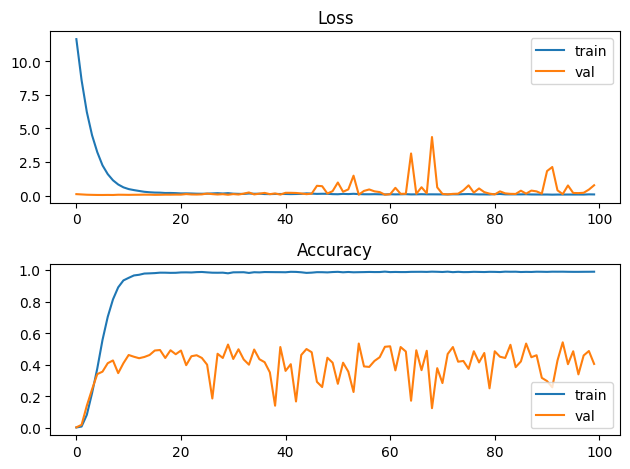

In [ ]:
plotTrainingHistory(train_history_soft, val_history_soft)

In [ ]:
def test_model(test_dataloader, model_name, loss_fn=loss_fn):
  checkpoint = torch.load(model_name)
  model.load_state_dict(checkpoint['model'])


  test_loss, test_acc = evaluate(test_dataloader, model, loss_fn)
  print(f"\nTest Loss: {test_loss:.3f} \nTest Accuracy: {test_acc:.3f}")

  return test_loss, test_acc

In [ ]:
test_loss, test_acc = test_model(test_dataloader_soft, 'best_model_soft.pth')

100%|██████████| 1432/1432 [00:03<00:00, 374.32it/s]


Test Loss: 0.343 
Test Accuracy: 0.040


In [ ]:
# Get the predications using a trained model
def getPredications(model: torch.nn.Module,
                  dataloader: torch.utils.data.DataLoader,
                  device: torch.device):

  model.eval()

  y_true = []
  y_pred = []

  for step, (img, label, label_oh) in enumerate(dataloader):

    img = img.to(device)
    label_oh = label_oh.float().to(device)

    # Predict the output of image
    pred = model(img)

    label_oh = label_oh.detach().cpu().numpy().reshape(-1, 5, characters_len)
    pred = pred.detach().cpu().numpy().reshape(-1, 5, characters_len)

    label_oh = np.squeeze(label_oh)
    pred = np.squeeze(pred)

    for i in range(0, 5):
        idx = np.argmax(pred[i, 0:characters_len])
        pred[i, 0:characters_len].fill(0)
        pred[i, idx] = 1



    y_true.append(label_oh)
    y_pred.append(pred)


  return np.array(y_true), np.array(y_pred)


In [ ]:
def confusionMatrix(y_true, y_pred):
  cm_sum = np.zeros((characters_len, characters_len), dtype=np.int32)

  for i in range(5):
    y_true_sub = y_true[:, i, :]
    y_pred_sub = y_pred[:, i, :]

    y_true_labels = np.argmax(y_true_sub, axis=1)
    y_pred_labels = np.argmax(y_pred_sub, axis=1)

    cm_sub = confusion_matrix(y_true_labels, y_pred_labels, labels=range(0, characters_len))
    cm_sum += cm_sub

  fig, ax = plt.subplots(figsize=(15, 15))
  cmd = ConfusionMatrixDisplay(confusion_matrix = cm_sum, display_labels = characters)
  cmd.plot(ax = ax)

  return cm_sum

In [ ]:
def getMetrics(conf_matrix):
    # Calculate precision, recall and f1-score for each class
    tp = np.diag(conf_matrix)
    fp = np.sum(conf_matrix, axis = 1) - tp
    fn = np.sum(conf_matrix, axis = 0) - tp
    tn = np.sum(conf_matrix) - (tp + fp + fn)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = (2 * precision * recall) / (precision + recall)

    # Calculate accuracy
    accuracy = np.sum(tp) / np.sum(conf_matrix)

    return [precision, recall, f1_score, accuracy]

In [ ]:
# Get predication for soft dataset
y_true, y_pred = getPredications(model, test_dataloader_soft, device)

<a id="ref5-2"></a>
## Confusion Matrix

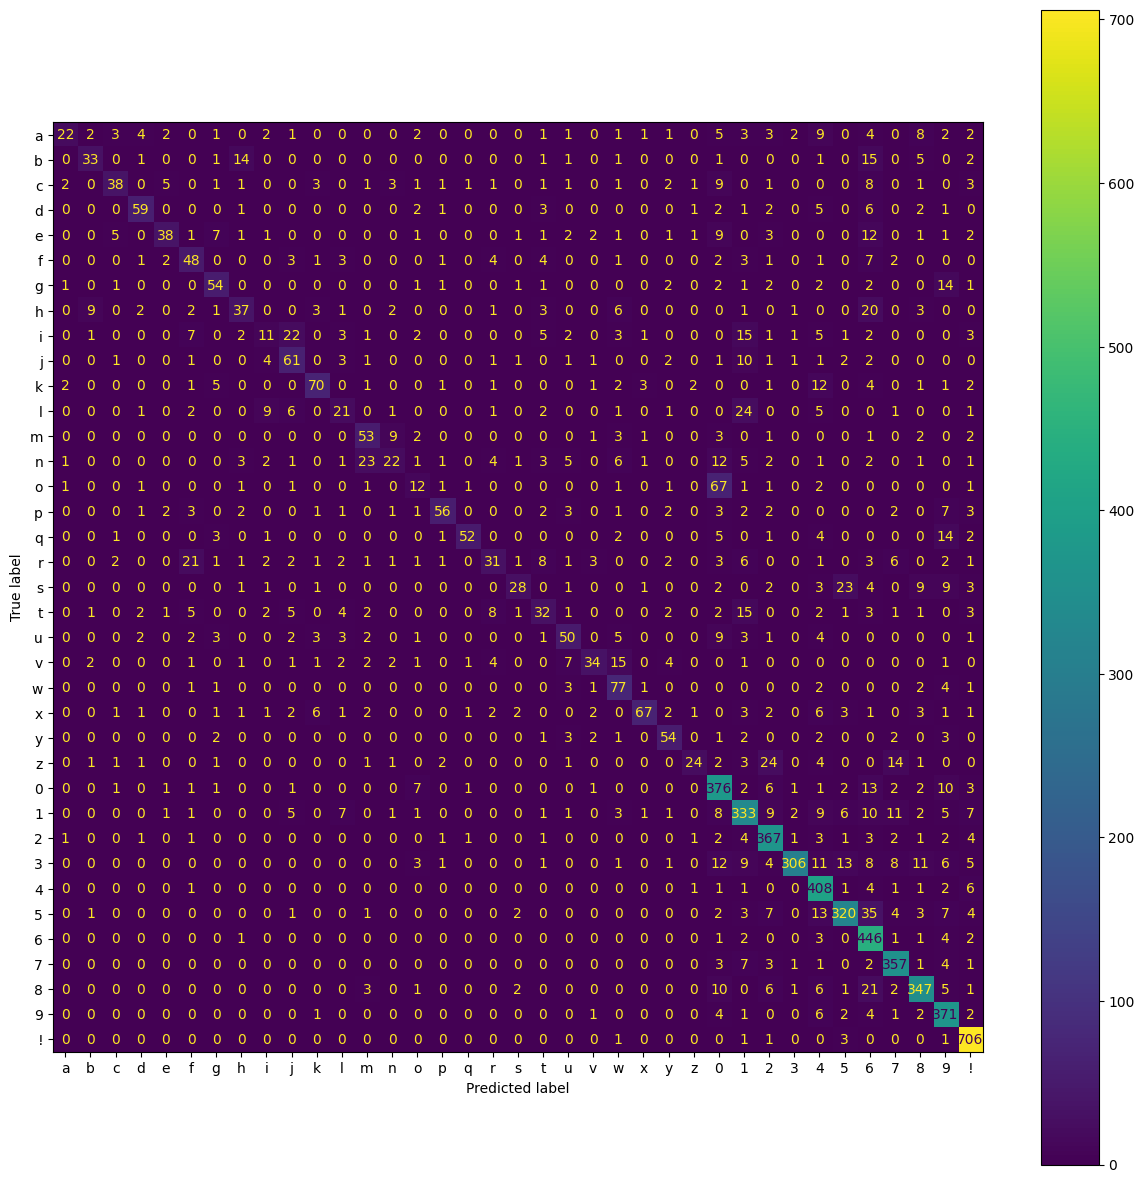

In [ ]:
from sklearn.metrics import confusion_matrix

# Get confusion matrix and show for soft dataset
conf_matrix = confusionMatrix(y_true, y_pred)

<a id="ref5-3"></a>
## Predictions

In [ ]:
def predict_single_image(image_path, model):
    image = Image.open(image_path).convert('L')
    transform = transforms.Compose([transforms.ToTensor()])
    image = transform(image).unsqueeze(0)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    model.to(device)

    with torch.no_grad():  # Disable gradient tracking for inference
        image = image.to(device)
        # Predict the output of the image
        pred = model(image)

    # Decode the predicted label
    predicted_label = decode_label(pred)
    return predicted_label

# Predict CAPTCHA images from the test dataset
test_images_path = '/content/CAPTCHA_dataset/CAPTCHA_dataset/soft/test/'
test_image_files = os.listdir(test_images_path)

for image_file in test_image_files[:20]:  # Predict for the first 20 images for example
    image_path = os.path.join(test_images_path, image_file)
    prediction = predict_single_image(image_path, model)
    print(f"Image: {image_file} \t Prediction: {prediction}")

Image: kxqg.png 	 Prediction: kxqq
Image: 84684.png 	 Prediction: 84684
Image: 36903.png 	 Prediction: 66033
Image: 8365.png 	 Prediction: 8365
Image: 40301.png 	 Prediction: 40301
Image: 54157.png 	 Prediction: 54157
Image: 8ucdn.png 	 Prediction: 8uan
Image: 6uft.png 	 Prediction: 6uft
Image: iskjy.png 	 Prediction: fskyy
Image: 6075.png 	 Prediction: 6075
Image: gval.png 	 Prediction: 9val
Image: 8onk.png 	 Prediction: 8bon
Image: 73991.png 	 Prediction: 73991
Image: 17875.png 	 Prediction: 17875
Image: 52772.png 	 Prediction: 52772
Image: 6153.png 	 Prediction: 6153
Image: 05810.png 	 Prediction: 03810
Image: yll20.png 	 Prediction: yll20
Image: j3i1.png 	 Prediction: u3r1
Image: 94q62.png 	 Prediction: 94962


<a id="ref6"></a>

# Hard Dataset

In [ ]:
train_history_hard, val_history_hard = run_model(train_dataloader_hard, validation_dataloader_hard, 'best_model_hard.pth',
                                                 'latest_model_hard_pth', num_epochs=100)


 Epoch 1


100%|██████████| 80/80 [00:12<00:00,  6.64it/s]


Train loss: 0.050 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 384.19it/s]


Val loss: 0.136 	 Val acc: 0.526

 Epoch 2


100%|██████████| 80/80 [00:10<00:00,  7.61it/s]


Train loss: 0.043 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 358.84it/s]


Val loss: 0.212 	 Val acc: 0.503

 Epoch 3


100%|██████████| 80/80 [00:10<00:00,  7.40it/s]


Train loss: 0.042 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 377.36it/s]


Val loss: 0.461 	 Val acc: 0.483

 Epoch 4


100%|██████████| 80/80 [00:10<00:00,  7.44it/s]


Train loss: 0.051 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 379.69it/s]


Val loss: 0.143 	 Val acc: 0.526

 Epoch 5


100%|██████████| 80/80 [00:10<00:00,  7.54it/s]


Train loss: 0.054 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 384.90it/s]


Val loss: 2.218 	 Val acc: 0.389

 Epoch 6


100%|██████████| 80/80 [00:10<00:00,  7.51it/s]


Train loss: 0.053 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 386.79it/s]


Val loss: 11.792 	 Val acc: 0.124

 Epoch 7


100%|██████████| 80/80 [00:10<00:00,  7.56it/s]


Train loss: 0.056 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 388.30it/s]


Val loss: 0.826 	 Val acc: 0.448

 Epoch 8


100%|██████████| 80/80 [00:10<00:00,  7.55it/s]


Train loss: 0.050 	 Train acc: 0.994


100%|██████████| 565/565 [00:01<00:00, 382.90it/s]


Val loss: 0.154 	 Val acc: 0.542

 Epoch 9


100%|██████████| 80/80 [00:10<00:00,  7.49it/s]


Train loss: 0.047 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 390.98it/s]


Val loss: 0.286 	 Val acc: 0.520

 Epoch 10


100%|██████████| 80/80 [00:10<00:00,  7.75it/s]


Train loss: 0.050 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 316.50it/s]


Val loss: 0.218 	 Val acc: 0.375

 Epoch 11


100%|██████████| 80/80 [00:10<00:00,  7.91it/s]


Train loss: 0.047 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 298.67it/s]


Val loss: 0.253 	 Val acc: 0.531

 Epoch 12


100%|██████████| 80/80 [00:09<00:00,  8.00it/s]


Train loss: 0.057 	 Train acc: 0.992


100%|██████████| 565/565 [00:01<00:00, 287.69it/s]


Val loss: 4.705 	 Val acc: 0.338

 Epoch 13


100%|██████████| 80/80 [00:10<00:00,  7.86it/s]


Train loss: 0.051 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 320.35it/s]


Val loss: 0.266 	 Val acc: 0.522

 Epoch 14


100%|██████████| 80/80 [00:10<00:00,  7.64it/s]


Train loss: 0.049 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 386.48it/s]


Val loss: 2.067 	 Val acc: 0.419

 Epoch 15


100%|██████████| 80/80 [00:10<00:00,  7.50it/s]


Train loss: 0.048 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 366.23it/s]


Val loss: 16.494 	 Val acc: 0.120

 Epoch 16


100%|██████████| 80/80 [00:10<00:00,  7.45it/s]


Train loss: 0.051 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 382.92it/s]


Val loss: 0.315 	 Val acc: 0.515

 Epoch 17


100%|██████████| 80/80 [00:10<00:00,  7.48it/s]


Train loss: 0.044 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 387.28it/s]


Val loss: 53.045 	 Val acc: 0.009

 Epoch 18


100%|██████████| 80/80 [00:10<00:00,  7.49it/s]


Train loss: 0.046 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 381.58it/s]


Val loss: 0.800 	 Val acc: 0.465

 Epoch 19


100%|██████████| 80/80 [00:10<00:00,  7.50it/s]


Train loss: 0.054 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 388.39it/s]


Val loss: 50.440 	 Val acc: 0.002

 Epoch 20


100%|██████████| 80/80 [00:10<00:00,  7.57it/s]


Train loss: 0.046 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 387.07it/s]


Val loss: 45.203 	 Val acc: 0.016

 Epoch 21


100%|██████████| 80/80 [00:10<00:00,  7.48it/s]


Train loss: 0.048 	 Train acc: 0.994


100%|██████████| 565/565 [00:01<00:00, 384.40it/s]


Val loss: 0.147 	 Val acc: 0.566

 Epoch 22


100%|██████████| 80/80 [00:10<00:00,  7.46it/s]


Train loss: 0.053 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 354.71it/s]


Val loss: 0.104 	 Val acc: 0.565

 Epoch 23


100%|██████████| 80/80 [00:10<00:00,  7.43it/s]


Train loss: 0.046 	 Train acc: 0.993


100%|██████████| 565/565 [00:02<00:00, 241.74it/s]


Val loss: 0.150 	 Val acc: 0.554

 Epoch 24


100%|██████████| 80/80 [00:10<00:00,  7.74it/s]


Train loss: 0.053 	 Train acc: 0.992


100%|██████████| 565/565 [00:01<00:00, 283.59it/s]


Val loss: 0.112 	 Val acc: 0.563

 Epoch 25


100%|██████████| 80/80 [00:10<00:00,  7.78it/s]


Train loss: 0.052 	 Train acc: 0.992


100%|██████████| 565/565 [00:01<00:00, 312.33it/s]


Val loss: 3.506 	 Val acc: 0.373

 Epoch 26


100%|██████████| 80/80 [00:10<00:00,  7.74it/s]


Train loss: 0.052 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 383.60it/s]


Val loss: 0.200 	 Val acc: 0.510

 Epoch 27


100%|██████████| 80/80 [00:10<00:00,  7.51it/s]


Train loss: 0.053 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 383.94it/s]


Val loss: 0.324 	 Val acc: 0.492

 Epoch 28


100%|██████████| 80/80 [00:10<00:00,  7.52it/s]


Train loss: 0.046 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 384.67it/s]


Val loss: 0.191 	 Val acc: 0.515

 Epoch 29


100%|██████████| 80/80 [00:10<00:00,  7.49it/s]


Train loss: 0.045 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 381.36it/s]


Val loss: 0.167 	 Val acc: 0.526

 Epoch 30


100%|██████████| 80/80 [00:10<00:00,  7.54it/s]


Train loss: 0.046 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 393.57it/s]


Val loss: 1.337 	 Val acc: 0.391

 Epoch 31


100%|██████████| 80/80 [00:10<00:00,  7.55it/s]


Train loss: 0.052 	 Train acc: 0.992


100%|██████████| 565/565 [00:01<00:00, 383.15it/s]


Val loss: 0.148 	 Val acc: 0.549

 Epoch 32


100%|██████████| 80/80 [00:10<00:00,  7.48it/s]


Train loss: 0.054 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 383.16it/s]


Val loss: 4.400 	 Val acc: 0.377

 Epoch 33


100%|██████████| 80/80 [00:10<00:00,  7.53it/s]


Train loss: 0.052 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 389.66it/s]


Val loss: 0.310 	 Val acc: 0.510

 Epoch 34


100%|██████████| 80/80 [00:10<00:00,  7.65it/s]


Train loss: 0.046 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 321.43it/s]


Val loss: 18.789 	 Val acc: 0.094

 Epoch 35


100%|██████████| 80/80 [00:10<00:00,  7.79it/s]


Train loss: 0.059 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 288.26it/s]


Val loss: 77.370 	 Val acc: 0.002

 Epoch 36


100%|██████████| 80/80 [00:10<00:00,  7.90it/s]


Train loss: 0.052 	 Train acc: 0.992


100%|██████████| 565/565 [00:01<00:00, 285.30it/s]


Val loss: 0.354 	 Val acc: 0.004

 Epoch 37


100%|██████████| 80/80 [00:10<00:00,  7.79it/s]


Train loss: 0.050 	 Train acc: 0.992


100%|██████████| 565/565 [00:01<00:00, 303.09it/s]


Val loss: 0.235 	 Val acc: 0.529

 Epoch 38


100%|██████████| 80/80 [00:10<00:00,  7.75it/s]


Train loss: 0.041 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 367.28it/s]


Val loss: 8.472 	 Val acc: 0.179

 Epoch 39


100%|██████████| 80/80 [00:10<00:00,  7.58it/s]


Train loss: 0.047 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 391.75it/s]


Val loss: 0.149 	 Val acc: 0.543

 Epoch 40


100%|██████████| 80/80 [00:10<00:00,  7.52it/s]


Train loss: 0.048 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 388.02it/s]


Val loss: 0.464 	 Val acc: 0.510

 Epoch 41


100%|██████████| 80/80 [00:10<00:00,  7.48it/s]


Train loss: 0.047 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 381.07it/s]


Val loss: 0.464 	 Val acc: 0.494

 Epoch 42


100%|██████████| 80/80 [00:10<00:00,  7.44it/s]


Train loss: 0.045 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 382.64it/s]


Val loss: 0.219 	 Val acc: 0.535

 Epoch 43


100%|██████████| 80/80 [00:10<00:00,  7.52it/s]


Train loss: 0.036 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 382.74it/s]


Val loss: 0.175 	 Val acc: 0.568

 Epoch 44


100%|██████████| 80/80 [00:10<00:00,  7.51it/s]


Train loss: 0.035 	 Train acc: 0.994


100%|██████████| 565/565 [00:01<00:00, 386.45it/s]


Val loss: 24.852 	 Val acc: 0.067

 Epoch 45


100%|██████████| 80/80 [00:10<00:00,  7.50it/s]


Train loss: 0.047 	 Train acc: 0.994


100%|██████████| 565/565 [00:01<00:00, 389.13it/s]


Val loss: 0.219 	 Val acc: 0.522

 Epoch 46


100%|██████████| 80/80 [00:10<00:00,  7.58it/s]


Train loss: 0.037 	 Train acc: 0.994


100%|██████████| 565/565 [00:01<00:00, 359.50it/s]


Val loss: 101.848 	 Val acc: 0.000

 Epoch 47


100%|██████████| 80/80 [00:10<00:00,  7.70it/s]


Train loss: 0.045 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 303.53it/s]


Val loss: 0.208 	 Val acc: 0.517

 Epoch 48


100%|██████████| 80/80 [00:10<00:00,  7.82it/s]


Train loss: 0.042 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 292.37it/s]


Val loss: 2.259 	 Val acc: 0.372

 Epoch 49


100%|██████████| 80/80 [00:10<00:00,  7.87it/s]


Train loss: 0.041 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 289.10it/s]


Val loss: 109.021 	 Val acc: 0.000

 Epoch 50


100%|██████████| 80/80 [00:10<00:00,  7.83it/s]


Train loss: 0.042 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 347.11it/s]


Val loss: 0.409 	 Val acc: 0.485

 Epoch 51


100%|██████████| 80/80 [00:11<00:00,  6.77it/s]


Train loss: 0.044 	 Train acc: 0.994


100%|██████████| 565/565 [00:01<00:00, 357.68it/s]


Val loss: 26.271 	 Val acc: 0.087

 Epoch 52


100%|██████████| 80/80 [00:10<00:00,  7.64it/s]


Train loss: 0.040 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 376.98it/s]


Val loss: 0.127 	 Val acc: 0.565

 Epoch 53


100%|██████████| 80/80 [00:10<00:00,  7.54it/s]


Train loss: 0.043 	 Train acc: 0.992


100%|██████████| 565/565 [00:01<00:00, 384.90it/s]


Val loss: 0.277 	 Val acc: 0.512

 Epoch 54


100%|██████████| 80/80 [00:10<00:00,  7.45it/s]


Train loss: 0.040 	 Train acc: 0.994


100%|██████████| 565/565 [00:01<00:00, 383.91it/s]


Val loss: 0.148 	 Val acc: 0.570

 Epoch 55


100%|██████████| 80/80 [00:10<00:00,  7.50it/s]


Train loss: 0.045 	 Train acc: 0.994


100%|██████████| 565/565 [00:01<00:00, 378.34it/s]


Val loss: 0.203 	 Val acc: 0.292

 Epoch 56


100%|██████████| 80/80 [00:11<00:00,  6.99it/s]


Train loss: 0.051 	 Train acc: 0.992


100%|██████████| 565/565 [00:01<00:00, 386.16it/s]


Val loss: 0.132 	 Val acc: 0.423

 Epoch 57


100%|██████████| 80/80 [00:10<00:00,  7.50it/s]


Train loss: 0.047 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 379.76it/s]


Val loss: 0.149 	 Val acc: 0.561

 Epoch 58


100%|██████████| 80/80 [00:10<00:00,  7.52it/s]


Train loss: 0.045 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 385.18it/s]


Val loss: 16.962 	 Val acc: 0.221

 Epoch 59


100%|██████████| 80/80 [00:11<00:00,  7.14it/s]


Train loss: 0.047 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 381.97it/s]


Val loss: 0.225 	 Val acc: 0.510

 Epoch 60


100%|██████████| 80/80 [00:10<00:00,  7.70it/s]


Train loss: 0.043 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 310.18it/s]


Val loss: 0.164 	 Val acc: 0.508

 Epoch 61


100%|██████████| 80/80 [00:10<00:00,  7.76it/s]


Train loss: 0.039 	 Train acc: 0.993


100%|██████████| 565/565 [00:02<00:00, 282.45it/s]


Val loss: 0.475 	 Val acc: 0.496

 Epoch 62


100%|██████████| 80/80 [00:10<00:00,  7.86it/s]


Train loss: 0.036 	 Train acc: 0.994


100%|██████████| 565/565 [00:02<00:00, 280.45it/s]


Val loss: 39.442 	 Val acc: 0.039

 Epoch 63


100%|██████████| 80/80 [00:10<00:00,  7.81it/s]


Train loss: 0.043 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 314.64it/s]


Val loss: 5.137 	 Val acc: 0.315

 Epoch 64


100%|██████████| 80/80 [00:10<00:00,  7.69it/s]


Train loss: 0.046 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 385.80it/s]


Val loss: 65.395 	 Val acc: 0.011

 Epoch 65


100%|██████████| 80/80 [00:10<00:00,  7.53it/s]


Train loss: 0.047 	 Train acc: 0.992


100%|██████████| 565/565 [00:01<00:00, 377.42it/s]


Val loss: 0.124 	 Val acc: 0.543

 Epoch 66


100%|██████████| 80/80 [00:10<00:00,  7.49it/s]


Train loss: 0.036 	 Train acc: 0.994


100%|██████████| 565/565 [00:01<00:00, 381.89it/s]


Val loss: 0.496 	 Val acc: 0.467

 Epoch 67


100%|██████████| 80/80 [00:10<00:00,  7.51it/s]


Train loss: 0.042 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 387.36it/s]


Val loss: 40.188 	 Val acc: 0.025

 Epoch 68


100%|██████████| 80/80 [00:11<00:00,  7.24it/s]


Train loss: 0.043 	 Train acc: 0.994


100%|██████████| 565/565 [00:01<00:00, 386.52it/s]


Val loss: 52.332 	 Val acc: 0.018

 Epoch 69


100%|██████████| 80/80 [00:10<00:00,  7.48it/s]


Train loss: 0.045 	 Train acc: 0.992


100%|██████████| 565/565 [00:01<00:00, 386.64it/s]


Val loss: 0.553 	 Val acc: 0.469

 Epoch 70


100%|██████████| 80/80 [00:10<00:00,  7.47it/s]


Train loss: 0.046 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 380.54it/s]


Val loss: 0.196 	 Val acc: 0.520

 Epoch 71


100%|██████████| 80/80 [00:10<00:00,  7.50it/s]


Train loss: 0.039 	 Train acc: 0.992


100%|██████████| 565/565 [00:01<00:00, 383.18it/s]


Val loss: 0.129 	 Val acc: 0.419

 Epoch 72


100%|██████████| 80/80 [00:10<00:00,  7.51it/s]


Train loss: 0.044 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 361.09it/s]


Val loss: 48.588 	 Val acc: 0.023

 Epoch 73


100%|██████████| 80/80 [00:10<00:00,  7.70it/s]


Train loss: 0.047 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 290.38it/s]


Val loss: 0.653 	 Val acc: 0.481

 Epoch 74


100%|██████████| 80/80 [00:10<00:00,  7.84it/s]


Train loss: 0.049 	 Train acc: 0.994


100%|██████████| 565/565 [00:01<00:00, 287.53it/s]


Val loss: 6.369 	 Val acc: 0.297

 Epoch 75


100%|██████████| 80/80 [00:10<00:00,  7.85it/s]


Train loss: 0.042 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 286.93it/s]


Val loss: 0.190 	 Val acc: 0.529

 Epoch 76


100%|██████████| 80/80 [00:10<00:00,  7.52it/s]


Train loss: 0.038 	 Train acc: 0.994


100%|██████████| 565/565 [00:01<00:00, 311.18it/s]


Val loss: 0.273 	 Val acc: 0.460

 Epoch 77


100%|██████████| 80/80 [00:10<00:00,  7.70it/s]


Train loss: 0.041 	 Train acc: 0.994


100%|██████████| 565/565 [00:01<00:00, 379.75it/s]


Val loss: 0.234 	 Val acc: 0.481

 Epoch 78


100%|██████████| 80/80 [00:10<00:00,  7.46it/s]


Train loss: 0.043 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 383.19it/s]


Val loss: 0.818 	 Val acc: 0.480

 Epoch 79


100%|██████████| 80/80 [00:10<00:00,  7.35it/s]


Train loss: 0.044 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 375.32it/s]


Val loss: 0.234 	 Val acc: 0.271

 Epoch 80


100%|██████████| 80/80 [00:10<00:00,  7.39it/s]


Train loss: 0.049 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 380.52it/s]


Val loss: 0.416 	 Val acc: 0.492

 Epoch 81


100%|██████████| 80/80 [00:10<00:00,  7.38it/s]


Train loss: 0.043 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 373.72it/s]


Val loss: 55.123 	 Val acc: 0.032

 Epoch 82


100%|██████████| 80/80 [00:10<00:00,  7.47it/s]


Train loss: 0.046 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 382.34it/s]


Val loss: 0.421 	 Val acc: 0.465

 Epoch 83


100%|██████████| 80/80 [00:10<00:00,  7.48it/s]


Train loss: 0.047 	 Train acc: 0.992


100%|██████████| 565/565 [00:01<00:00, 376.75it/s]


Val loss: 0.310 	 Val acc: 0.503

 Epoch 84


100%|██████████| 80/80 [00:10<00:00,  7.47it/s]


Train loss: 0.041 	 Train acc: 0.994


100%|██████████| 565/565 [00:01<00:00, 381.34it/s]


Val loss: 1.826 	 Val acc: 0.402

 Epoch 85


100%|██████████| 80/80 [00:10<00:00,  7.45it/s]


Train loss: 0.040 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 382.77it/s]


Val loss: 0.310 	 Val acc: 0.515

 Epoch 86


100%|██████████| 80/80 [00:10<00:00,  7.52it/s]


Train loss: 0.049 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 319.40it/s]


Val loss: 0.178 	 Val acc: 0.538

 Epoch 87


100%|██████████| 80/80 [00:10<00:00,  7.72it/s]


Train loss: 0.041 	 Train acc: 0.994


100%|██████████| 565/565 [00:01<00:00, 286.40it/s]


Val loss: 5.557 	 Val acc: 0.301

 Epoch 88


100%|██████████| 80/80 [00:10<00:00,  7.79it/s]


Train loss: 0.038 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 284.53it/s]


Val loss: 0.206 	 Val acc: 0.536

 Epoch 89


100%|██████████| 80/80 [00:10<00:00,  7.31it/s]


Train loss: 0.046 	 Train acc: 0.994


100%|██████████| 565/565 [00:02<00:00, 278.99it/s]


Val loss: 47.313 	 Val acc: 0.025

 Epoch 90


100%|██████████| 80/80 [00:10<00:00,  7.73it/s]


Train loss: 0.026 	 Train acc: 0.994


100%|██████████| 565/565 [00:01<00:00, 314.61it/s]


Val loss: 60.864 	 Val acc: 0.012

 Epoch 91


100%|██████████| 80/80 [00:10<00:00,  7.63it/s]


Train loss: 0.041 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 381.89it/s]


Val loss: 0.271 	 Val acc: 0.241

 Epoch 92


100%|██████████| 80/80 [00:10<00:00,  7.53it/s]


Train loss: 0.040 	 Train acc: 0.994


100%|██████████| 565/565 [00:01<00:00, 380.23it/s]


Val loss: 5.304 	 Val acc: 0.287

 Epoch 93


100%|██████████| 80/80 [00:10<00:00,  7.43it/s]


Train loss: 0.043 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 381.48it/s]


Val loss: 0.126 	 Val acc: 0.570

 Epoch 94


100%|██████████| 80/80 [00:10<00:00,  7.41it/s]


Train loss: 0.040 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 384.07it/s]


Val loss: 0.141 	 Val acc: 0.554

 Epoch 95


100%|██████████| 80/80 [00:10<00:00,  7.48it/s]


Train loss: 0.044 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 383.86it/s]


Val loss: 0.190 	 Val acc: 0.543

 Epoch 96


100%|██████████| 80/80 [00:10<00:00,  7.44it/s]


Train loss: 0.036 	 Train acc: 0.994


100%|██████████| 565/565 [00:01<00:00, 378.33it/s]


Val loss: 18.176 	 Val acc: 0.161

 Epoch 97


100%|██████████| 80/80 [00:10<00:00,  7.42it/s]


Train loss: 0.040 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 383.21it/s]


Val loss: 0.279 	 Val acc: 0.535

 Epoch 98


100%|██████████| 80/80 [00:10<00:00,  7.37it/s]


Train loss: 0.038 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 381.94it/s]


Val loss: 0.172 	 Val acc: 0.556

 Epoch 99


100%|██████████| 80/80 [00:10<00:00,  7.50it/s]


Train loss: 0.045 	 Train acc: 0.994


100%|██████████| 565/565 [00:01<00:00, 359.70it/s]


Val loss: 0.213 	 Val acc: 0.527

 Epoch 100


100%|██████████| 80/80 [00:10<00:00,  7.62it/s]


Train loss: 0.038 	 Train acc: 0.993


100%|██████████| 565/565 [00:01<00:00, 298.19it/s]


Val loss: 1.536 	 Val acc: 0.448
Finished


<a id="ref6-1"></a>
## Training evolution

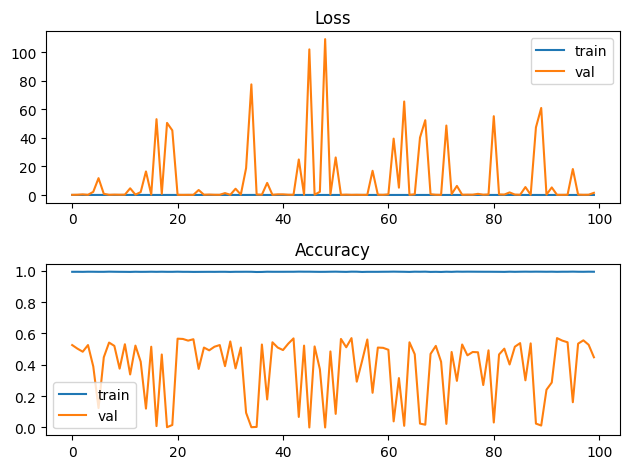

In [ ]:
plotTrainingHistory(train_history_hard, val_history_hard)

In [ ]:
test_loss, test_acc = test_model(test_dataloader_hard, 'best_model_hard.pth')

100%|██████████| 1433/1433 [00:03<00:00, 382.81it/s]


Test Loss: 0.541 
Test Accuracy: 0.113


In [ ]:
y_true_hard, y_pred_hard = getPredications(model, test_dataloader_hard, device)

<a id="ref6-2"></a>
## Confusion Matrix

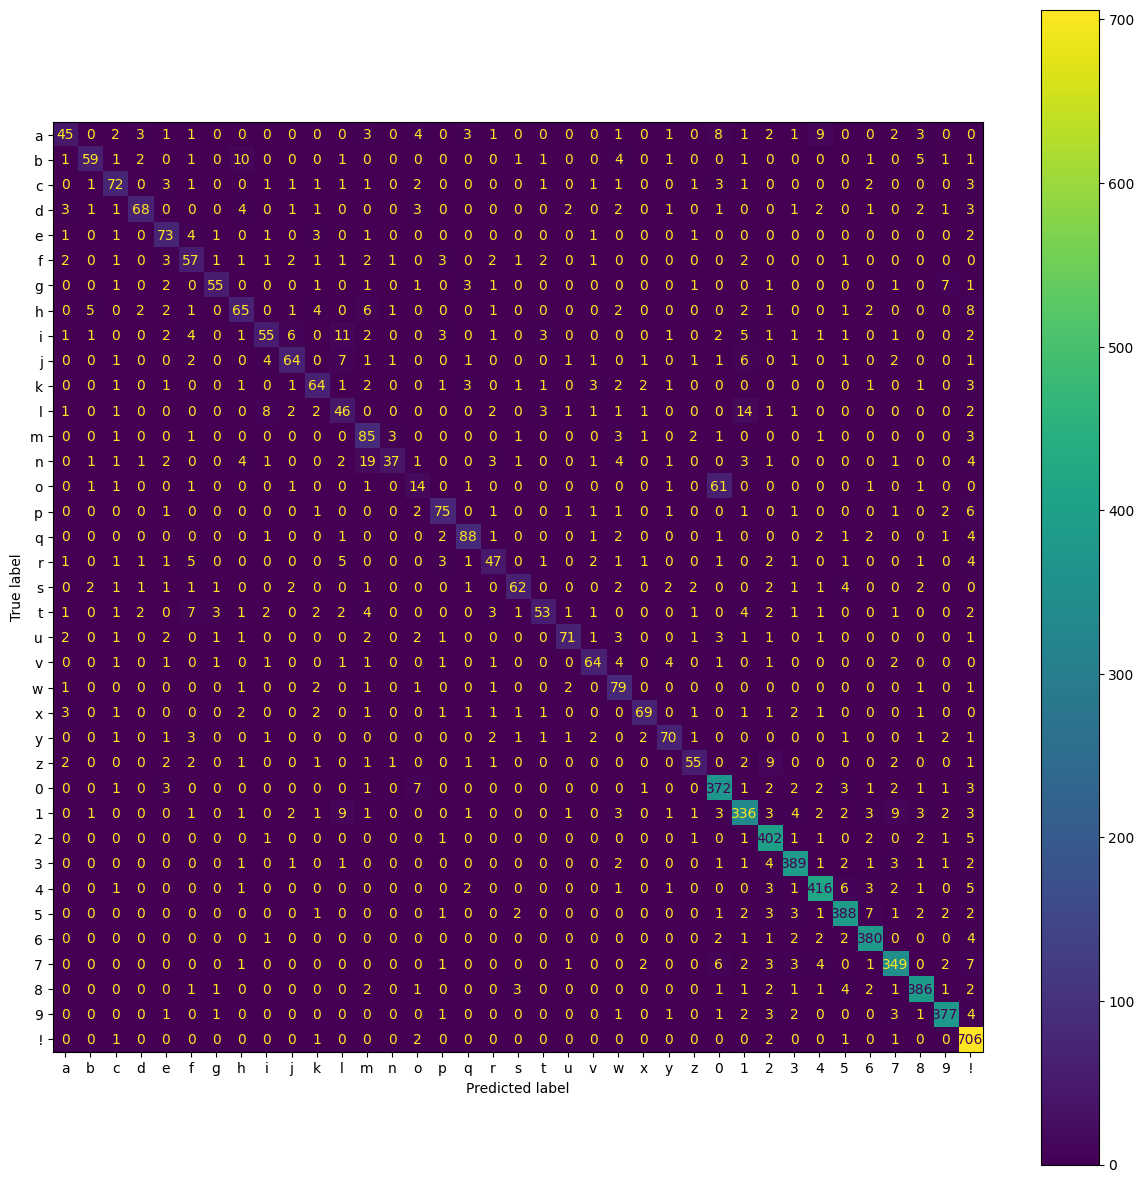

In [ ]:
conf_matrix_2 = confusionMatrix(y_true_hard, y_pred_hard)

<a id="ref6-3"></a>

## Predictions

In [ ]:
# Predict CAPTCHA images from the test dataset
test_images_path = '/content/CAPTCHA_dataset/CAPTCHA_dataset/hard/test/'
test_image_files = os.listdir(test_images_path)

for image_file in test_image_files[:20]:  # Predict for the first 20 images for example
    image_path = os.path.join(test_images_path, image_file)
    prediction = predict_single_image(image_path, model)
    print(f"Image: {image_file} \t Prediction: {prediction}")

Image: 64644.png 	 Prediction: 64644
Image: 4a4sg.png 	 Prediction: 484gg
Image: 3n1r4.png 	 Prediction: 3h1r4
Image: 9994.png 	 Prediction: 9994
Image: 5327.png 	 Prediction: 5327
Image: 7864.png 	 Prediction: 7864
Image: nij7.png 	 Prediction: nif7
Image: 4dwu8.png 	 Prediction: 4dww8
Image: 63345.png 	 Prediction: 63345
Image: 2iny.png 	 Prediction: 2iny
Image: 0972.png 	 Prediction: 0972
Image: im5e.png 	 Prediction: lm5e
Image: jint.png 	 Prediction: iimt
Image: tj8g.png 	 Prediction: tj8q
Image: clp0a.png 	 Prediction: clo0a
Image: fpaxq.png 	 Prediction: fpaxq
Image: 1131.png 	 Prediction: 1131
Image: 4183.png 	 Prediction: 4183
Image: 2rjj.png 	 Prediction: 2rjj
Image: 78nv.png 	 Prediction: 787m


<a id="ref7"></a>
# Conclusion, limitations & future work

Several approachs were tested during this project, although most of them did not improve our results. Among them, we tried additional convolutional layers and different data augmentation techiques (Random Perspective, Random Rotation, Random Resized Crop, Random Horizontal Flip, Random Vertical Flip and Random Adjust Sharpness) to get a model with more depth, in terms of finding more patterns on each image.


Different hyper parameters were tested, such as several kernel sizes, different loss functions as well as different optimizers. To each convolutional layer, some hyper parameter tuning was also performed.


In our final approach feeded the model with the complete image, instead of split by characters.

With regard to the soft dataset, the best model had almost 0.55 of accuracy in the validation data. Although, when it comes to apply the model to the test data, our model not performed well.

Concerning the hard dataset, the results were a bit surprising since our model improved slightly when in comparison with the perfomance obtained in the soft dataset. The best model had almost 0.6 of accuracy in the validation data, and in the test data the results improved a bit despite of they did not accomplish our goal.


By observing the confusion matrix, is possible to confirm that there are some difficulties to distinguish some characters such as "f" and "j", "0" and "O", "1" and "l".

<a id="ref7-1"></a>
## Limitations

Regarding limitations, there were several to mention here.

- The most impactaful was lack of computational power. This came with model's complexity. Each complete training was almost 12 hours, so we decided to buy colab pro in order to overcome this issue.

- We tried to slice each character, to make it easier to the model, but this approach was not sucessful because some of them were to close to each other, which turned it impossible to split during our timespan. We choose not to follow with this approach.

- Our model was designed to decode captchas with four and five characters, so chaptchas with more or less characters can not be decoded through our model.



<a id="ref7-2"></a>
## Future work

As future work, we would like to improve our model's accuracy. Besides that, we really would like to implement the "Slice Approach", since in our knowledge this could improve the results.

It would be also interesting to create a dynamic model, that would be capable of decoding capatchas regardless of their length.

<a id="ref7-3"></a>
## Conclusion

As final conclusion, we are satisfied with our achievements although our results were below our expectations.

In general, our pipeline works well but some hyper parameter tuning and may be changing in nertwork's architecture can improve model's results. Pre trained models were not the main goal of this project, but they can contribute to also improve the results.

To wrap up, our group learned so many things during this project that can be very useful to our future life.